In [37]:
%pip install imbalanced-learn

   ---------------------------------------- 0.0/238.4 kB ? eta -:--:--
   ---------- ----------------------------- 61.4/238.4 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 238.4/238.4 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
X = pd.read_csv('train_values_transformed/X.csv', sep=',')
y = pd.read_csv('train_values_transformed/y.csv', sep=',')

X = X.drop(columns=['Unnamed: 0'], axis=1)
y = y.drop(columns=['Unnamed: 0'], axis=1)

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

In [40]:
y_train

,status_group
31258,1
8528,3
73045,2
40216,2
74474,2
...,...
73147,2
66558,1
16023,3
45643,3


In [3]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/31 [00:00<?, ?it/s]

 39%|███▊      | 12/31 [00:35<00:36,  1.94s/it]

: 

: 

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [3]:
n_samples = len(y_train)

class_count = y_train['status_group'].value_counts().to_dict()
n_classes = len(class_count)

class_weights = {}

for j in class_count:
  n_samplesj = class_count[j]
  class_weights[j] = n_samples / (n_classes * n_samplesj)
  
print(class_weights)

{1: 1.0, 3: 1.0, 2: 1.0}


In [3]:
# clf = RandomForestClassifier(max_depth=32, random_state=1, class_weight=class_weights)
clf = RandomForestClassifier(max_depth=32, random_state=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Model accuracy: {accuracy}')

Model accuracy: 0.8706344286009506


In [4]:
def ConfusionMatrix(y_pred, labels):
	print(classification_report(y_test, y_pred))
	cm = confusion_matrix(y_test, y_pred, labels=labels)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
	disp.plot()

              precision    recall  f1-score   support

           1       0.34      0.32      0.33      6452
           2       0.34      0.35      0.34      6452
           3       0.34      0.34      0.34      6452

    accuracy                           0.34     19356
   macro avg       0.34      0.34      0.34     19356
weighted avg       0.34      0.34      0.34     19356



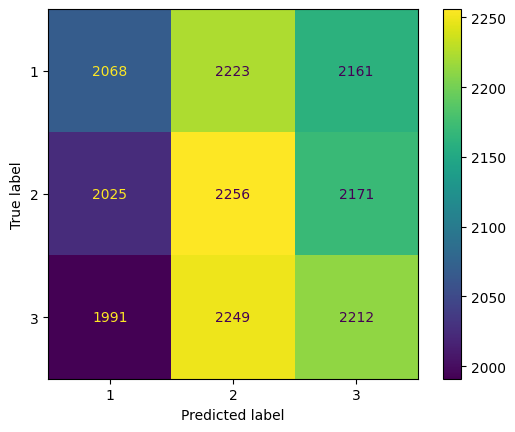

In [5]:
ConfusionMatrix(y_pred, [1, 2, 3])

In [3]:
def ApplyGridSearch(classifier, param_grid):
	# Definir el método de división externa (por ejemplo, K-Folds con 5 divisiones)
	outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

	# Definir el método de división interna para la búsqueda de hiperparámetros
	inner_kf = KFold(n_splits=3, shuffle=True, random_state=42)

	# Realizar la búsqueda de hiperparámetros con validación cruzada anidada
	grid_search = GridSearchCV(classifier, param_grid, cv=inner_kf, verbose=3)

	nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_kf)

	# Imprimir los puntajes de rendimiento
	print("Puntajes de validación cruzada anidada:", nested_scores)
	print("Puntaje promedio:", nested_scores.mean())

	# Entrenar el modelo con la búsqueda de hiperparámetros
	grid_search.fit(X_train, y_train)

	return grid_search

In [4]:
def ApplyRandomSearch(classifier, param_dist):
	# Definir el método de división externa (por ejemplo, K-Folds con 5 divisiones)
	outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

	# Crear un modelo RandomizedSearchCV con el clasificador y el espacio de búsqueda
	random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=20, cv=3, random_state=42, verbose=3)

	# Realizar la búsqueda de hiperparámetros con validación cruzada anidada
	nested_scores = cross_val_score(random_search, X_train, y_train, cv=outer_kf)

	# Imprimir los puntajes de rendimiento
	print("Puntajes de validación cruzada anidada:", nested_scores)
	print("Puntaje promedio:", nested_scores.mean())

	# Entrenar el modelo con la búsqueda de hiperparámetros
	random_search.fit(X_train, y_train)

	return random_search

https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv

In [ ]:
param_grid = [
  { 
    'n_estimators': [250, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [16, 32],
    'criterion' :['gini', 'entropy']
	}
 ]

grid_search = ApplyGridSearch(RandomForestClassifier(random_state=1), param_grid)

# Acceder al modelo entrenado con los hiperparámetros óptimos
RandomForestClassifier_model_grid_search = grid_search.best_estimator_

y_pred = RandomForestClassifier_model_grid_search.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')
print(grid_search.best_estimator_)

# CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)

# y_pred = CV_rfc.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# report = classification_report(y_val, y_pred)

# print('---------------------------------')
# print(f'Precisión del modelo: {accuracy}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.821 total time=  14.9s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.815 total time=  14.6s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.814 total time=  14.5s
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.821 total time=  29.2s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.815 total time=  29.2s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.815 total time=  29.0s
[CV 1/3] END criterion=gini, max_depth=16, max_features=log2, n_estimators=250;, score=0.821 total time=  12.3s
[CV 2/3] END criterion=gini, max_depth=16, max_features=log2, n_estimators=250;, score=0.813 total time=  12.5s
[CV 3/3] END criterion=gini, max_depth=16, 

In [8]:
os.mkdir('output_models')
joblib.dump(RandomForestClassifier_model_grid_search, 'output_models/RandomForestClassifier_model_grid_search.pkl')

['output_models/RandomForestClassifier_model_grid_search.pkl']

In [5]:
param_dist = [
  { 
    'n_estimators': [250, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [16, 32],
    'criterion' :['gini', 'entropy']
	}
 ]

random_search = ApplyRandomSearch(RandomForestClassifier(random_state=1), param_dist)

# Acceder al modelo entrenado con los hiperparámetros óptimos
RandomForestClassifier_model_random_search = random_search.best_estimator_

y_pred = RandomForestClassifier_model_random_search.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')
print(random_search.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.790 total time=   7.6s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.793 total time=   7.6s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.787 total time=   7.7s
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.789 total time=  15.1s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.792 total time=  16.0s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.787 total time=  15.8s
[CV 1/3] END criterion=gini, max_depth=16, max_features=log2, n_estimators=250;, score=0.790 total time=   6.6s
[CV 2/3] END criterion=gini, max_depth=16, max_features=log2, n_estimators=250;, score=0.792 total time=   6.6s
[CV 3/3] END criterion=gini, max_depth=16, 

NameError: name 'grid_search' is not defined

In [6]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=32, max_features='log2', n_estimators=500,
                       random_state=1)


In [7]:
joblib.dump(RandomForestClassifier_model_random_search, 'output_models/RandomForestClassifier_model_random_search.pkl')

['output_models/RandomForestClassifier_model_random_search.pkl']

In [9]:
RandomForestClassifier_model_grid_search = joblib.load('output_models/RandomForestClassifier_model_grid_search.pkl')

In [5]:
def ConfusionMatrix(y_pred, labels):
	print(classification_report(y_test, y_pred))
	cm = confusion_matrix(y_test, y_pred, labels=labels)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
	disp.plot()

              precision    recall  f1-score   support

           1       0.34      0.32      0.33      6452
           2       0.34      0.35      0.34      6452
           3       0.34      0.34      0.34      6452

    accuracy                           0.34     19356
   macro avg       0.34      0.34      0.34     19356
weighted avg       0.34      0.34      0.34     19356



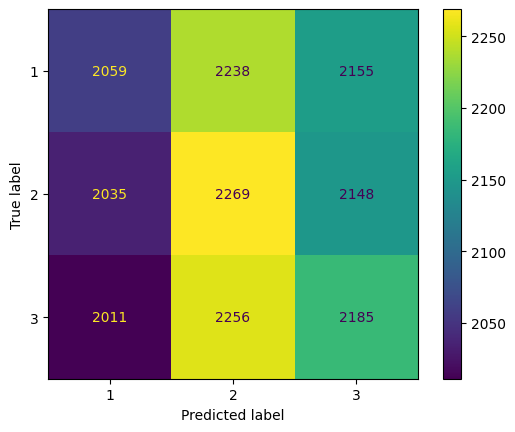

In [6]:
ConfusionMatrix(y_pred, [1, 2, 3])